 # Term Project: Compress a Pretrained Model on CIFAR10 Dataset
 ## Required Libraries & Versions

In [1]:
import numpy as np
import torch
import torch.nn.utils.prune as prune
import torchvision
import os
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
import tqdm
from timeit import default_timer as timer
import copy

ROOT = os.getcwd()


In [2]:
print('numpy :',np.__version__)
print('torch :',torch.__version__)
print('torchvision :',torchvision.__version__)
print('matplotlib :',matplotlib.__version__)
print('pandas :',pd.__version__)
print('tqdm  :',tqdm.__version__)


numpy : 1.22.0
torch : 1.10.1
torchvision : 0.11.2
matplotlib : 3.5.1
pandas : 1.3.5
tqdm  : 4.62.3


## Hardware Specs

In [3]:
import platform,socket,re,uuid,json,psutil,logging

def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['architecture']=platform.machine()
        info['hostname']=socket.gethostname()
        info['ip-address']=socket.gethostbyname(socket.gethostname())
        # info['mac-address']=':'.join(re.findall('..', '%012x' % uuid.getnode()))
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())


{'platform': 'Linux',
 'platform-release': '5.4.0-96-generic',
 'platform-version': '#109~18.04.1-Ubuntu SMP Thu Jan 13 15:06:26 UTC 2022',
 'architecture': 'x86_64',
 'hostname': 'cagnur-G3-3500',
 'ip-address': '127.0.1.1',
 'processor': 'x86_64',
 'ram': '15 GB'}

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
GeForce GTX 1650 Ti


### Set CPU 
As we need CPU Inference time, set to CPU 

In [5]:
device =torch.device("cpu")
print(device)

cpu


## Uncompressed Model
We will use pretrained model from Ref 1, https://github.com/huyvnphan/PyTorch_CIFAR10

In [6]:
MODEL_PATH = os.path.join(ROOT, 'PyTorch_CIFAR10-master')
os.chdir(MODEL_PATH)
from cifar10_models.googlenet import googlenet

In [7]:
os.getcwd()

'/home/cagnur/Desktop/MMI7/Term_Project/PyTorch_CIFAR10-master'

In [8]:
uncompressed_model =  googlenet(pretrained=True)
# uncompressed_model = pretrained_model.to(device=device)

### Model Size

In [9]:
os.chdir(ROOT)
summary(uncompressed_model, (3,32,32))
torch.save(uncompressed_model.state_dict(), "/tmp/uncompressed.h5")

!gzip -qf /tmp/uncompressed.h5
!du -h /tmp/uncompressed.h5.gz

Layer (type:depth-idx)                   Output Shape              Param #
├─BasicConv2d: 1-1                       [-1, 192, 32, 32]         --
|    └─Conv2d: 2-1                       [-1, 192, 32, 32]         5,184
|    └─BatchNorm2d: 2-2                  [-1, 192, 32, 32]         384
├─Inception: 1-2                         [-1, 256, 32, 32]         --
|    └─BasicConv2d: 2-3                  [-1, 64, 32, 32]          --
|    |    └─Conv2d: 3-1                  [-1, 64, 32, 32]          12,288
|    |    └─BatchNorm2d: 3-2             [-1, 64, 32, 32]          128
|    └─Sequential: 2-4                   [-1, 128, 32, 32]         --
|    |    └─BasicConv2d: 3-3             [-1, 96, 32, 32]          18,624
|    |    └─BasicConv2d: 3-4             [-1, 128, 32, 32]         110,848
|    └─Sequential: 2-5                   [-1, 32, 32, 32]          --
|    |    └─BasicConv2d: 3-5             [-1, 16, 32, 32]          3,104
|    |    └─BasicConv2d: 3-6             [-1, 32, 32, 32]       

>The results are consistent with the Ref 1: It states that the number of parameters is 5.491 M and the parameter size is 22MB

## Compressed Model
We will use Pytroch pruning. The listed pages help me to construct the following cell:
* https://pytorch.org/tutorials/intermediate/pruning_tutorial.html
* https://spell.ml/blog/model-pruning-in-pytorch-X9pXQRAAACIAcH9h
* https://intellabs.github.io/distiller/tutorial-lang_model.html#using-distiller-to-prune-a-pytorch-language-model


In [10]:
def prune_model_l1_unstructured(model, layer_type, proportion):
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            # print(module)
            prune.l1_unstructured(module, 'weight', proportion)
            prune.remove(module, 'weight')
    return model
def prune_model_l1_structured(model, layer_type, proportion):
    for module_name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.ln_structured(module, 'weight', proportion, n=1, dim=1)
            prune.remove(module, 'weight')
    return model


compressed_0p1_model =  prune_model_l1_unstructured(copy.deepcopy(uncompressed_model), torch.nn.Conv2d, 0.1)
compressed_0p3_model =  prune_model_l1_unstructured(copy.deepcopy(uncompressed_model), torch.nn.Conv2d, 0.3)
compressed_0p5_model =  prune_model_l1_unstructured(copy.deepcopy(uncompressed_model), torch.nn.Conv2d, 0.5)
compressed_0p7_model =  prune_model_l1_unstructured(copy.deepcopy(uncompressed_model), torch.nn.Conv2d, 0.7)
compressed_0p9_model =  prune_model_l1_unstructured(copy.deepcopy(uncompressed_model), torch.nn.Conv2d, 0.9)

compressed_0p1_structured_model =  prune_model_l1_structured(copy.deepcopy(uncompressed_model), torch.nn.Conv2d, 0.1)
compressed_0p3_structured_model =  prune_model_l1_structured(copy.deepcopy(uncompressed_model), torch.nn.Conv2d, 0.3)
compressed_0p5_structured_model =  prune_model_l1_structured(copy.deepcopy(uncompressed_model), torch.nn.Conv2d, 0.5)
compressed_0p7_structured_model =  prune_model_l1_structured(copy.deepcopy(uncompressed_model), torch.nn.Conv2d, 0.7)
compressed_0p9_structured_model =  prune_model_l1_structured(copy.deepcopy(uncompressed_model), torch.nn.Conv2d, 0.9)


In [11]:
torch.save(compressed_0p1_model.state_dict(), "/tmp/compressed_0p1_model.h5")

!gzip -qf /tmp/compressed_0p1_model.h5
!du -h /tmp/compressed_0p1_model.h5.gz

19M	/tmp/compressed_0p1_model.h5.gz


In [12]:
torch.save(compressed_0p3_model.state_dict(), "/tmp/compressed_0p3_model.h5")

!gzip -qf /tmp/compressed_0p3_model.h5
!du -h /tmp/compressed_0p3_model.h5.gz

16M	/tmp/compressed_0p3_model.h5.gz


In [13]:
torch.save(compressed_0p5_model.state_dict(), "/tmp/compressed_0p5_model.h5")

!gzip -qf /tmp/compressed_0p5_model.h5
!du -h /tmp/compressed_0p5_model.h5.gz

12M	/tmp/compressed_0p5_model.h5.gz


In [14]:
torch.save(compressed_0p7_model.state_dict(), "/tmp/compressed_0p7_model.h5")

!gzip -qf /tmp/compressed_0p7_model.h5
!du -h /tmp/compressed_0p7_model.h5.gz

7,9M	/tmp/compressed_0p7_model.h5.gz


In [15]:
torch.save(compressed_0p9_model.state_dict(), "/tmp/compressed_0p9_model.h5")

!gzip -qf /tmp/compressed_0p9_model.h5
!du -h /tmp/compressed_0p9_model.h5.gz

3,8M	/tmp/compressed_0p9_model.h5.gz


In [16]:
torch.save(compressed_0p1_structured_model.state_dict(), "/tmp/compressed_0p1_structured_model.h5")

!gzip -qf /tmp/compressed_0p1_structured_model.h5
!du -h /tmp/compressed_0p1_structured_model.h5.gz

19M	/tmp/compressed_0p1_structured_model.h5.gz


In [17]:
torch.save(compressed_0p3_structured_model.state_dict(), "/tmp/compressed_0p3_structured_model.h5")

!gzip -qf /tmp/compressed_0p3_structured_model.h5
!du -h /tmp/compressed_0p3_structured_model.h5.gz

15M	/tmp/compressed_0p3_structured_model.h5.gz


In [18]:
torch.save(compressed_0p5_structured_model.state_dict(), "/tmp/compressed_0p5_structured_model.h5")

!gzip -qf /tmp/compressed_0p5_structured_model.h5
!du -h /tmp/compressed_0p5_structured_model.h5.gz

12M	/tmp/compressed_0p5_structured_model.h5.gz


In [19]:
torch.save(compressed_0p7_structured_model.state_dict(), "/tmp/compressed_0p7_structured_model.h5")

!gzip -qf /tmp/compressed_0p7_structured_model.h5
!du -h /tmp/compressed_0p7_structured_model.h5.gz

7,8M	/tmp/compressed_0p7_structured_model.h5.gz


In [20]:
torch.save(compressed_0p9_structured_model.state_dict(), "/tmp/compressed_0p9_structured_model.h5")

!gzip -qf /tmp/compressed_0p9_structured_model.h5
!du -h /tmp/compressed_0p9_structured_model.h5.gz

3,7M	/tmp/compressed_0p9_structured_model.h5.gz


In [21]:
print('Uncompressed Model Size is 20M')
print("Compressed Models' Size are in the following table where the unit is in 'M'")
model_size = {}
model_size['Proportion'] = ['0.1','0.3','0.5','0.7','0.9']
model_size['l1_unstructed'] = [19,16,12,7.9,3.8]
model_size['l1_structed'] = [19,15,12,7.8,3.7]
df = pd.DataFrame.from_dict(model_size, orient='columns').set_index('Proportion')
display(df)


Uncompressed Model Size is 20M
Compressed Models' Size are in the following table where the unit is in 'M'


,l1_unstructed,l1_structed
Proportion,,
0.1,19.0,19.0
0.3,16.0,15.0
0.5,12.0,12.0
0.7,7.9,7.8
0.9,3.8,3.7


## Data
### Download
Donwload CIFAR10 for training and test dataset  -> we will just use test dataset.
The following operations are set according to PyTorch_CIFAR10 git repo
* Mean and std values -> data.py -> init()
* The transformations -> data.py -> val_dataloader() function
* Batch size ->  train.py (It was 256, I changed with 32 because of "CUDA OUT OF MEMORY .... " error)
* Num of workers -> train.py 

In [22]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)
transform = torchvision.transforms.Compose(
            [
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std),
            ]
            )
BATCH = 32
NUM_WORKERS = 8

In [23]:
cifar10_train = torchvision.datasets.CIFAR10(root='CIFAR10/train', train= True, download= True, transform=transform)
cifar10_test = torchvision.datasets.CIFAR10(root='CIFAR10/test', train= False, download= True, transform=transform)

# train_loader = torch.utils.data.DataLoader(cifar10_train, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS)
test_loader = torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS)

Files already downloaded and verified
Files already downloaded and verified


### Visualize
Ref 2: https://stdworkflow.com/500/pytorch-cifar10-image-classification-data-loading-and-visualization

In [24]:
df = pd.DataFrame.from_dict(data=cifar10_test.class_to_idx, columns=[ 'Id'], orient ='index' )
display(df)

,Id
airplane,0
automobile,1
bird,2
cat,3
deer,4
dog,5
frog,6
horse,7
ship,8
truck,9


In [25]:
dataset_info = { 'Total training data':cifar10_train.data.shape[0], 'Total test data': cifar10_test.data.shape[0], 'Img Dimension': cifar10_test.data.shape[1:]}
display(pd.DataFrame.from_dict(dataset_info, orient='index', columns=['Explanation']))

,Explanation
Total training data,50000
Total test data,10000
Img Dimension,"(32, 32, 3)"


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


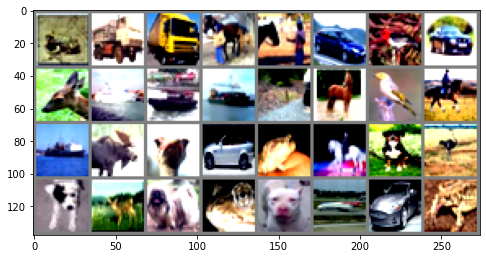

In [26]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)
im,label = iter(test_loader).next()
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

Check whether tensor uses cpu or gpu:

In [27]:
print(im.device)

cpu


## Comparison
### Test Accuracy and CPU Inference Time
Accuracy is straightforward. 
In order to understand what is CPU Inference time, I check the following pages:
* https://github.com/facebookresearch/Detectron/issues/13#:~:text=Inference%20times%20are%20often%20expressed,reduced%20substantially%20with%20additional%20engineering.)
* https://towardsdatascience.com/the-correct-way-to-measure-inference-time-of-deep-neural-networks-304a54e5187f
* https://medium.com/huggingface/benchmarking-transformers-pytorch-and-tensorflow-e2917fb891c2#:~:text=Across%20all%20models%2C%20on%20CPU,inference%20time%20of%200.043s.
* https://discuss.pytorch.org/t/how-to-measure-time-in-pytorch/26964
* https://leimao.github.io/blog/PyTorch-Benchmark/#:~:text=The%20time%20stamp%20of%20events%20could%20be%20measured%20on%20CPU%20using%20implementations%20such%20as%20time%20or%20timeit%20in%20Python.%20It%20could%20also%20be%20measured%20on%20CUDA%20using%20CUDA%20event%20such%20as%20the%20PyTorch%20torch.cuda.Event%20CUDA%20event%20wrapper.


In [28]:
def get_cpu_inference_time_and_test_acc(model, test_loader, test_data_size):
    model = model.cuda()
    # Wam-up
    # Because I sequentially run each cell above, and they includes for loop, I assume the CPU is warmed up
    torch.cuda.synchronize()
    elapsed_time_ms = 0
    start = timer()
    # Start Inference Phase
    correct = 0
    with torch.no_grad():
        for imgs, labels in tqdm.tqdm(test_loader):
            imgs, labels = imgs.cuda(), labels.cuda()
            # imgs, labels = imgs, labels
            out = model(imgs)
            predictions = out.argmax(dim=1, keepdim=True)  
            correct += predictions.eq(labels.view_as(predictions)).sum().item()
    accuracy = correct/len(test_loader.dataset)
    print(accuracy)
    # End of inference Phase
    torch.cuda.synchronize()
    end = timer()
    elapsed_time_ms = (end - start) * 1000
    per_sample = elapsed_time_ms/test_data_size
    print("CPU Inference time is " + str(per_sample)+ ' ms')
    return per_sample, accuracy

In [29]:
torch.cuda.empty_cache()
criterion=torch.nn.CrossEntropyLoss()
uncompressed_model.eval()
cpu_inf_time, acc = get_cpu_inference_time_and_test_acc(uncompressed_model, test_loader, dataset_info['Total test data'])

100%|█████████████████████████████████████████| 313/313 [00:14<00:00, 20.90it/s]

0.9285
CPU Inference time is 1.4980145456999936 ms


> The accuracy is consistent with the Ref 1:it states that the model accuracy is 92.85%

In [30]:
# 
compressed_0p1_model.eval()
compressed_0p3_model.eval()
compressed_0p5_model.eval()
compressed_0p7_model.eval()
compressed_0p9_model.eval()
compressed_0p1_structured_model.eval()
compressed_0p3_structured_model.eval()
compressed_0p5_structured_model.eval()
compressed_0p7_structured_model.eval()
compressed_0p9_structured_model.eval()
#
cpu_inf_time_0p1, acc_0p1 = get_cpu_inference_time_and_test_acc(compressed_0p1_model, test_loader, dataset_info['Total test data'])
cpu_inf_time_0p3, acc_0p3 = get_cpu_inference_time_and_test_acc(compressed_0p3_model, test_loader, dataset_info['Total test data'])
cpu_inf_time_0p5, acc_0p5 = get_cpu_inference_time_and_test_acc(compressed_0p5_model, test_loader, dataset_info['Total test data'])
cpu_inf_time_0p7, acc_0p7 = get_cpu_inference_time_and_test_acc(compressed_0p7_model, test_loader, dataset_info['Total test data'])
cpu_inf_time_0p9, acc_0p9 = get_cpu_inference_time_and_test_acc(compressed_0p9_model, test_loader, dataset_info['Total test data'])
cpu_inf_time_0p1_structured, acc_0p1_structured = get_cpu_inference_time_and_test_acc(compressed_0p1_structured_model, test_loader, dataset_info['Total test data'])
cpu_inf_time_0p3_structured, acc_0p3_structured = get_cpu_inference_time_and_test_acc(compressed_0p3_structured_model, test_loader, dataset_info['Total test data'])
cpu_inf_time_0p5_structured, acc_0p5_structured = get_cpu_inference_time_and_test_acc(compressed_0p5_structured_model, test_loader, dataset_info['Total test data'])
cpu_inf_time_0p7_structured, acc_0p7_structured = get_cpu_inference_time_and_test_acc(compressed_0p7_structured_model, test_loader, dataset_info['Total test data'])
cpu_inf_time_0p9_structured, acc_0p9_structured = get_cpu_inference_time_and_test_acc(compressed_0p9_structured_model, test_loader, dataset_info['Total test data'])

100%|█████████████████████████████████████████| 313/313 [00:14<00:00, 21.18it/s]


0.9284
CPU Inference time is 1.4778010991999964 ms


100%|█████████████████████████████████████████| 313/313 [00:14<00:00, 21.11it/s]


0.928
CPU Inference time is 1.4832306832999962 ms


100%|█████████████████████████████████████████| 313/313 [00:14<00:00, 20.94it/s]


0.9266
CPU Inference time is 1.4948030599999926 ms


100%|█████████████████████████████████████████| 313/313 [00:14<00:00, 21.06it/s]


0.8924
CPU Inference time is 1.4865433567999957 ms


100%|█████████████████████████████████████████| 313/313 [00:14<00:00, 21.23it/s]


0.126
CPU Inference time is 1.474209152200001 ms


100%|█████████████████████████████████████████| 313/313 [00:14<00:00, 20.87it/s]


0.9282
CPU Inference time is 1.4999011443000088 ms


100%|█████████████████████████████████████████| 313/313 [00:14<00:00, 20.91it/s]


0.4642
CPU Inference time is 1.4973318747999997 ms


100%|█████████████████████████████████████████| 313/313 [00:14<00:00, 20.93it/s]


0.2503
CPU Inference time is 1.4959536103000006 ms


100%|█████████████████████████████████████████| 313/313 [00:15<00:00, 20.85it/s]


0.1312
CPU Inference time is 1.5016181223999978 ms


100%|█████████████████████████████████████████| 313/313 [00:14<00:00, 21.39it/s]

0.1
CPU Inference time is 1.4631393156999932 ms


In [31]:
cpu_data = {'l1_unstructed': [cpu_inf_time_0p1, 
                              cpu_inf_time_0p3,
                              cpu_inf_time_0p5,
                              cpu_inf_time_0p7,
                              cpu_inf_time_0p9],
           'l1_structed': [cpu_inf_time_0p1_structured,
                            cpu_inf_time_0p3_structured,
                            cpu_inf_time_0p5_structured,
                            cpu_inf_time_0p7_structured,
                            cpu_inf_time_0p9_structured],
           'Proportion': ['0.1','0.3','0.5','0.7','0.9']}
cpu_df = pd.DataFrame.from_dict(cpu_data, orient='columns').set_index('Proportion')
display(cpu_df)

,l1_unstructed,l1_structed
Proportion,,
0.1,1.477801,1.499901
0.3,1.483231,1.497332
0.5,1.494803,1.495954
0.7,1.486543,1.501618
0.9,1.474209,1.463139


In [33]:
acc_data = {'l1_unstructed': [acc_0p1, 
                              acc_0p3,
                              acc_0p5,
                              acc_0p7,
                              acc_0p9],
           'l1_structed': [acc_0p1_structured,
                            acc_0p3_structured,
                            acc_0p5_structured,
                            acc_0p7_structured,
                            acc_0p9_structured],
           'Proportion': ['0.1','0.3','0.5','0.7','0.9']}
acc_df = pd.DataFrame.from_dict(acc_data, orient='columns').set_index('Proportion')
display(acc_df)

,l1_unstructed,l1_structed
Proportion,,
0.1,0.9284,0.9282
0.3,0.9280,0.4642
0.5,0.9266,0.2503
0.7,0.8924,0.1312
0.9,0.1260,0.1000
